In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
orders_items = pd.read_csv("final_data/orders_items.csv", index_col=0)
orders = pd.read_csv("final_data/orders.csv", index_col=0)
products = pd.read_csv("final_data/products.csv")
product_category = pd.read_csv("final_data/product_category_name_translation.csv")

In [3]:
print(products.isna().sum())
print(orders.isna().sum())
print(product_category.isna().sum())

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
product_category_name            0
product_category_name_english    0
dtype: int64


In [4]:
orders.dropna(inplace=True)
orders.reset_index(inplace=True)
orders = orders[orders['order_status']=='delivered']
orders_items.drop(columns=['shipping_limit_date_1', 'price_2', 'freight_value_3'], inplace=True)
orders_items.columns = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
orders_items.dropna(inplace=True)
orders_items.reset_index(inplace=True)
products.dropna(inplace=True)

In [5]:
print(products.isna().sum())
print(orders.isna().sum())
print(product_category.isna().sum())

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64
product_category_name            0
product_category_name_english    0
dtype: int64


### ABC/XYZ-анализ по продуктам

In [6]:
product_stats = (
    orders
    .merge(orders_items, on='order_id')
    .merge(products, on='product_id')
    # .merge(product_category, on='product_category_name')
)
print(len(product_stats))
product_stats.head(2)

108636


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,id,order_item_id,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,100785,1,...,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,36896,1,...,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0


In [7]:
prod_info = product_stats[['order_id', 'order_purchase_timestamp', 'price', 'freight_value', 'product_category_name', 'product_id']].copy()
prod_info['order_purchase_timestamp'] = pd.to_datetime(prod_info['order_purchase_timestamp'])
prod_info['revenue'] = prod_info['price'] + prod_info['freight_value']
prod_info['year'] = pd.DatetimeIndex(prod_info['order_purchase_timestamp']).year
prod_info['month'] = pd.DatetimeIndex(prod_info['order_purchase_timestamp']).month
prod_info.head(1)

,order_id,order_purchase_timestamp,price,freight_value,product_category_name,product_id,revenue,year,month
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,2017-10-02 10:56:33,29.99,8.72,utilidades_domesticas,87285b34-8845-7264-7811-a353c7ac498a,38.71,2017,10


In [8]:
df_xyz = prod_info.groupby(['product_id', 'year','month'])['revenue'].sum().to_frame().reset_index()
df_xyz['month'] = df_xyz['month'].map("{:02}".format)
df_xyz['year_month'] = df_xyz['year'].map(str) + '-' + df_xyz['month'].map(str)
df_xyz.head()

,product_id,year,month,revenue,year_month
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,2018,05,120.24,2018-05
1,00088930-e925-c41f-d95e-bfe695fd2655,2017,12,143.83,2017-12
2,0009406f-d747-9715-e4be-f61dd91f2462,2017,12,242.10,2017-12
3,000b8f95-fcb9-e009-6488-278317764d19,2018,08,157.00,2018-08
4,000d9be2-9b52-07b5-4e86-aa1b1ac54872,2018,04,218.27,2018-04


In [9]:
df_xyz = df_xyz.pivot(index='product_id', columns='year_month', values='revenue').reset_index().fillna(0)

In [10]:
df_xyz.head(1)

year_month,product_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.24,0.0,0.0,0.0


In [11]:
len(df_xyz.columns) - 1

23

In [12]:
df_xyz.iloc[:,1:24].head(1)

year_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.24,0.0,0.0,0.0


In [13]:
df_xyz['total_sales'] = df_xyz.iloc[:,1:24].sum(axis=1,numeric_only=True)
df_xyz.head(1)

year_month,product_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,120.24,0.0,0.0,0.0,120.24


In [14]:
df_xyz['avg_sales'] = df_xyz['total_sales']/23
df_xyz['std'] = df_xyz.iloc[:,1:24].std(axis=1)
df_xyz['CoV']=df_xyz['std']/df_xyz['avg_sales']
df_xyz.head(2)

year_month,product_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales,avg_sales,std,CoV
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,120.24,0.0,0.0,0.0,120.24,5.227826,25.071773,4.795832
1,00088930-e925-c41f-d95e-bfe695fd2655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,143.83,6.253478,29.990628,4.795832


In [15]:
def condition_xyz(x):
    if x<=0.5:
        return "X"
    elif x>=0.5 and x<=1:
        return "Y"
    else:
        return 'Z'

In [16]:
df_xyz['XYZ']=df_xyz['CoV'].apply(condition_xyz)
df_xyz.head(2)

year_month,product_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales,avg_sales,std,CoV,XYZ
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,120.24,0.0,0.0,0.0,120.24,5.227826,25.071773,4.795832,Z
1,00088930-e925-c41f-d95e-bfe695fd2655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,143.83,6.253478,29.990628,4.795832,Z


In [17]:
df_abc = df_xyz.groupby('product_id').agg(total_revenue=('total_sales','sum')).sort_values(by='total_revenue', ascending=False).reset_index()

In [18]:
df_abc.head()

,product_id,total_revenue
0,bb50f2e2-36e5-eea0-1006-80137654686c,67258.03
1,d1c42706-0a0f-73f6-b889-a5c7c61f2ac4,58957.31
2,6cdd5384-3498-f928-9054-4667809f1595,57933.73
3,99a4788c-b248-5696-5c36-a24e339b6058,49907.50
4,3dd2a171-68ec-895c-781a-9191c1e95ad7,47876.06


In [19]:
df_abc['rev_cum_sum'] = df_abc['total_revenue'].cumsum()
df_abc['rev_all'] = df_abc['total_revenue'].sum()
df_abc['sku_rev_percent'] = df_abc['rev_cum_sum'] / df_abc['rev_all']
df_abc.head(100)

,product_id,total_revenue,rev_cum_sum,rev_all,sku_rev_percent
0,bb50f2e2-36e5-eea0-1006-80137654686c,67258.03,67258.03,15216655.08,0.004420
1,d1c42706-0a0f-73f6-b889-a5c7c61f2ac4,58957.31,126215.34,15216655.08,0.008295
2,6cdd5384-3498-f928-9054-4667809f1595,57933.73,184149.07,15216655.08,0.012102
3,99a4788c-b248-5696-5c36-a24e339b6058,49907.50,234056.57,15216655.08,0.015382
4,3dd2a171-68ec-895c-781a-9191c1e95ad7,47876.06,281932.63,15216655.08,0.018528
...,...,...,...,...,...
95,0a57f7d2-c983-bcf8-1885-89a5fea4a8da,10874.76,1990205.66,15216655.08,0.130791
96,a50acd33-ba7a-8da8-e9db-65094fa990a4,10862.26,2001067.92,15216655.08,0.131505
97,fbce4c4c-b307-679d-89a3-bf3d3bb353b9,10801.62,2011869.54,15216655.08,0.132215
98,53ea9da4-85f6-aed8-a6f0-3a85831fe021,10749.92,2022619.46,15216655.08,0.132921


In [20]:
def condition_abc(x):
    if x>0 and x<=0.80:
        return "A"
    elif x>0.80 and x<=0.90:
        return "B"
    else:
        return 'C'

df_abc['ABC'] = df_abc['sku_rev_percent'].apply(condition_abc)
df_abc.tail()

,product_id,total_revenue,rev_cum_sum,rev_all,sku_rev_percent,ABC
31620,47a83ac8-45f9-53b8-8915-4d9963dbc1f8,10.88,15216614.99,15216655.08,0.999997,C
31621,9334fc63-bffa-67f6-85c0-3b1dc24df180,10.48,15216625.47,15216655.08,0.999998,C
31622,310dc320-5890-3b64-16c7-1faff132df9e,10.07,15216635.54,15216655.08,0.999999,C
31623,d51e0a7f-437c-0d14-f560-082ed007fd85,9.95,15216645.49,15216655.08,0.999999,C
31624,46fce52c-ef5c-aa7c-c225-a5531c946c8b,9.59,15216655.08,15216655.08,1.000000,C


In [21]:
df_abc_check = df_abc.groupby('ABC').agg(total_revenue=('total_revenue', 'sum')).reset_index()
prod_info.head()

,order_id,order_purchase_timestamp,price,freight_value,product_category_name,product_id,revenue,year,month
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,2017-10-02 10:56:33,29.99,8.72,utilidades_domesticas,87285b34-8845-7264-7811-a353c7ac498a,38.71,2017,10
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,2018-07-24 20:41:37,118.70,22.76,perfumaria,595fac2a-385a-c33a-80bd-5114aec74eb8,141.46,2018,7
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,2018-08-08 08:38:49,159.90,19.22,automotivo,aa4383b3-73c6-aca5-d879-7843e5594415,179.12,2018,8
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,2017-11-18 19:28:06,45.00,27.20,pet_shop,d0b61bfb-1de8-32b1-5ba9-d266ca96e5b0,72.20,2017,11
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,2018-02-13 21:18:39,19.90,8.72,papelaria,65266b2d-a20d-04db-e00c-5c2d3bb7859e,28.62,2018,2


In [22]:
df_abc_xyz = (
    df_xyz[['product_id', 'total_sales', 'avg_sales', 'std', 'CoV', 'XYZ']]
    .merge(df_abc[['product_id', 'total_revenue', 'ABC']], on='product_id', how='left')
)
df_abc_xyz.head()

,product_id,total_sales,avg_sales,std,CoV,XYZ,total_revenue,ABC
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,120.24,5.227826,25.071773,4.795832,Z,120.24,C
1,00088930-e925-c41f-d95e-bfe695fd2655,143.83,6.253478,29.990628,4.795832,Z,143.83,C
2,0009406f-d747-9715-e4be-f61dd91f2462,242.10,10.526087,50.481340,4.795832,Z,242.10,B
3,000b8f95-fcb9-e009-6488-278317764d19,157.00,6.826087,32.736763,4.795832,Z,157.00,C
4,000d9be2-9b52-07b5-4e86-aa1b1ac54872,218.27,9.490000,45.512441,4.795832,Z,218.27,B


In [23]:
df_abc_xyz['ABC_XYZ']=df_abc_xyz['ABC'].astype(str) + df_abc_xyz['XYZ'].astype(str)
df_abc_xyz.head()

,product_id,total_sales,avg_sales,std,CoV,XYZ,total_revenue,ABC,ABC_XYZ
0,00066f42-aeeb-9f30-0754-8bb9d3f33c38,120.24,5.227826,25.071773,4.795832,Z,120.24,C,CZ
1,00088930-e925-c41f-d95e-bfe695fd2655,143.83,6.253478,29.990628,4.795832,Z,143.83,C,CZ
2,0009406f-d747-9715-e4be-f61dd91f2462,242.10,10.526087,50.481340,4.795832,Z,242.10,B,BZ
3,000b8f95-fcb9-e009-6488-278317764d19,157.00,6.826087,32.736763,4.795832,Z,157.00,C,CZ
4,000d9be2-9b52-07b5-4e86-aa1b1ac54872,218.27,9.490000,45.512441,4.795832,Z,218.27,B,BZ


**Results:**

In [24]:
df_abc_xyz.groupby('ABC_XYZ').agg(
    total_sales=('total_sales', 'sum'),
    average_sales =('avg_sales', 'sum')
).reset_index().sort_values(by='total_sales', ascending=False)

,ABC_XYZ,total_sales,average_sales
1,AZ,11895215.59,517183.286522
2,BZ,1521829.47,66166.498696
3,CZ,1521711.66,66161.376522
0,AY,277898.36,12082.537391


**Pareto check:**

In [25]:
print("Процент товаров сегмента A среди всех товаров")
print(round(len(df_abc_xyz[df_abc_xyz['ABC']=='A'])/len(df_abc_xyz)*100, 3))

Процент товаров сегмента A среди всех товаров
28.177


In [26]:
print("Процент выручки от товаров сегмента A:")
print(round(df_abc_xyz[df_abc_xyz['ABC']=='A']['total_revenue'].sum()/df_abc_xyz['total_revenue'].sum()*100, 3))

Процент выручки от товаров сегмента A:
79.999


**ratio**

In [27]:
(df_abc_xyz['ABC'].value_counts() / len(df_abc_xyz)*100).to_frame(name='ratio (%)')

,ratio (%)
ABC,
C,52.543874
A,28.177075
B,19.279051


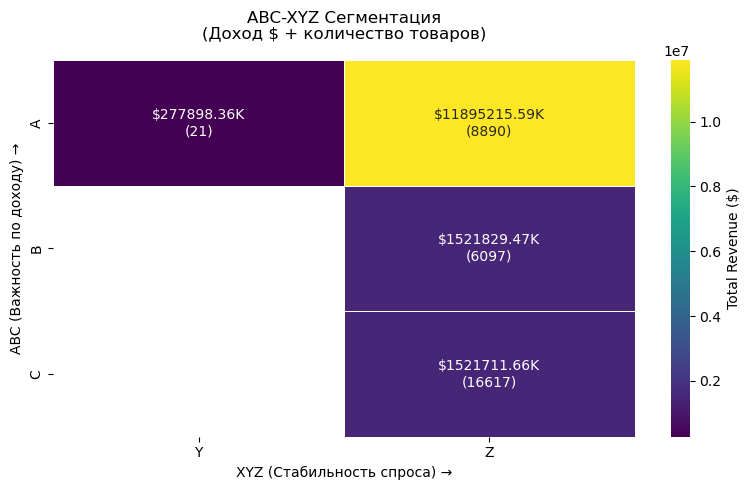

In [28]:
revenue_tab = pd.crosstab(
    index=df_abc_xyz['ABC'],
    columns=df_abc_xyz['XYZ'],
    values=df_abc_xyz['total_revenue'],
    aggfunc='sum'
)

count_tab = pd.crosstab(
    index=df_abc_xyz['ABC'],
    columns=df_abc_xyz['XYZ']
)

# Create combined annotations
annotations = np.array([
    [f"${revenue}K\n({count})" 
     for revenue, count in zip(revenue_row, count_row)]
    for revenue_row, count_row in zip(revenue_tab.values, count_tab.values)
])

# Plot clean heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    revenue_tab,
    annot=annotations,
    fmt='',
    cmap='viridis',
    linewidths=0.5,
    cbar_kws={'label': 'Total Revenue ($)'}
)

plt.title('ABC-XYZ Сегментация\n(Доход $ + количество товаров)', pad=15)
plt.xlabel('XYZ (Стабильность спроса) →')
plt.ylabel('ABC (Важность по доходу) →')
plt.tight_layout()
plt.show()

### ABC/XYZ-анализ по категориям товаров

In [29]:
product_stats = (
    orders
    .merge(orders_items, on='order_id')
    .merge(products, on='product_id')
    # .merge(product_category, on='product_category_name')
)
print(len(product_stats))
product_stats.head(2)

108636


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,id,order_item_id,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,9ef432eb-6251-2973-04e7-6186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,100785,1,...,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,b0830fb4-747a-6c6d-20de-a0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,36896,1,...,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0


In [30]:
prod_info = product_stats[['order_id', 'order_purchase_timestamp', 'price', 'freight_value', 'product_category_name', 'product_id']].copy()
prod_info['order_purchase_timestamp'] = pd.to_datetime(prod_info['order_purchase_timestamp'])
prod_info['revenue'] = prod_info['price'] + prod_info['freight_value']
prod_info['year'] = pd.DatetimeIndex(prod_info['order_purchase_timestamp']).year
prod_info['month'] = pd.DatetimeIndex(prod_info['order_purchase_timestamp']).month
prod_info.head(1)

,order_id,order_purchase_timestamp,price,freight_value,product_category_name,product_id,revenue,year,month
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,2017-10-02 10:56:33,29.99,8.72,utilidades_domesticas,87285b34-8845-7264-7811-a353c7ac498a,38.71,2017,10


In [31]:
df_xyz = prod_info.groupby(['product_category_name', 'year','month'])['revenue'].sum().to_frame().reset_index()
df_xyz['month'] = df_xyz['month'].map("{:02}".format)
df_xyz['year_month'] = df_xyz['year'].map(str) + '-' + df_xyz['month'].map(str)
df_xyz.head()

,product_category_name,year,month,revenue,year_month
0,agro_industria_e_comercio,2017,01,107.76,2017-01
1,agro_industria_e_comercio,2017,02,331.10,2017-02
2,agro_industria_e_comercio,2017,03,110.69,2017-03
3,agro_industria_e_comercio,2017,05,1763.74,2017-05
4,agro_industria_e_comercio,2017,06,1422.05,2017-06


In [32]:
df_xyz = df_xyz.pivot(index='product_category_name', columns='year_month', values='revenue').reset_index().fillna(0)

In [33]:
df_xyz.head(1)

year_month,product_category_name,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
0,agro_industria_e_comercio,0.0,0.0,0.0,107.76,331.1,110.69,0.0,1763.74,1422.05,...,14610.32,5664.04,6296.51,8031.41,5639.49,4783.66,3433.22,3843.05,7520.33,5543.74


In [34]:
len(df_xyz.columns) - 1

23

In [35]:
df_xyz.iloc[:,1:24].head(1)

year_month,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
0,0.0,0.0,0.0,107.76,331.1,110.69,0.0,1763.74,1422.05,1199.47,...,14610.32,5664.04,6296.51,8031.41,5639.49,4783.66,3433.22,3843.05,7520.33,5543.74


In [36]:
df_xyz['total_sales'] = df_xyz.iloc[:,1:24].sum(axis=1,numeric_only=True)
df_xyz.head(1)

year_month,product_category_name,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales
0,agro_industria_e_comercio,0.0,0.0,0.0,107.76,331.1,110.69,0.0,1763.74,1422.05,...,5664.04,6296.51,8031.41,5639.49,4783.66,3433.22,3843.05,7520.33,5543.74,76203.3


In [37]:
df_xyz['avg_sales'] = df_xyz['total_sales']/23
df_xyz['std'] = df_xyz.iloc[:,1:24].std(axis=1)
df_xyz['CoV']=df_xyz['std']/df_xyz['avg_sales']
df_xyz.head(2)

year_month,product_category_name,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales,avg_sales,std,CoV
0,agro_industria_e_comercio,0.0,0.00,0.0,107.76,331.10,110.69,0.00,1763.74,1422.05,...,5639.49,4783.66,3433.22,3843.05,7520.33,5543.74,76203.30,3313.186957,3628.545191,1.095183
1,alimentos,0.0,96.23,0.0,78.82,875.25,2830.01,611.15,452.25,171.79,...,2068.59,2219.99,2079.48,1693.59,4401.42,9571.13,35794.68,1556.290435,2050.210686,1.317370


In [38]:
def condition_xyz(x):
    if x<=0.5:
        return "X"
    elif x>=0.5 and x<=1:
        return "Y"
    else:
        return 'Z'

In [39]:
df_xyz['XYZ']=df_xyz['CoV'].apply(condition_xyz)
df_xyz.head(2)

year_month,product_category_name,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2018-04,2018-05,2018-06,2018-07,2018-08,total_sales,avg_sales,std,CoV,XYZ
0,agro_industria_e_comercio,0.0,0.00,0.0,107.76,331.10,110.69,0.00,1763.74,1422.05,...,4783.66,3433.22,3843.05,7520.33,5543.74,76203.30,3313.186957,3628.545191,1.095183,Z
1,alimentos,0.0,96.23,0.0,78.82,875.25,2830.01,611.15,452.25,171.79,...,2219.99,2079.48,1693.59,4401.42,9571.13,35794.68,1556.290435,2050.210686,1.317370,Z


In [40]:
df_abc = df_xyz.groupby('product_category_name').agg(total_revenue=('total_sales','sum')).sort_values(by='total_revenue', ascending=False).reset_index()

In [41]:
df_abc.head()

,product_category_name,total_revenue
0,beleza_saude,1412089.53
1,relogios_presentes,1264016.98
2,cama_mesa_banho,1225052.07
3,esporte_lazer,1117968.45
4,informatica_acessorios,1032603.65


In [42]:
df_abc['rev_cum_sum'] = df_abc['total_revenue'].cumsum()
df_abc['rev_all'] = df_abc['total_revenue'].sum()
df_abc['sku_rev_percent'] = df_abc['rev_cum_sum'] / df_abc['rev_all']
df_abc.head(100)

,product_category_name,total_revenue,rev_cum_sum,rev_all,sku_rev_percent
0,beleza_saude,1412089.53,1412089.53,15216655.08,0.092799
1,relogios_presentes,1264016.98,2676106.51,15216655.08,0.175867
2,cama_mesa_banho,1225052.07,3901158.58,15216655.08,0.256374
3,esporte_lazer,1117968.45,5019127.03,15216655.08,0.329844
4,informatica_acessorios,1032603.65,6051730.68,15216655.08,0.397704
...,...,...,...,...,...
68,pc_gamer,1430.10,15213606.33,15216655.08,0.999800
69,casa_conforto_2,1170.58,15214776.91,15216655.08,0.999877
70,cds_dvds_musicais,954.99,15215731.90,15216655.08,0.999939
71,fashion_roupa_infanto_juvenil,598.67,15216330.57,15216655.08,0.999979


In [43]:
def condition_abc(x):
    if x>0 and x<=0.80:
        return "A"
    elif x>0.80 and x<=0.90:
        return "B"
    else:
        return 'C'

df_abc['ABC'] = df_abc['sku_rev_percent'].apply(condition_abc)
df_abc.tail()

,product_category_name,total_revenue,rev_cum_sum,rev_all,sku_rev_percent,ABC
68,pc_gamer,1430.10,15213606.33,15216655.08,0.999800,C
69,casa_conforto_2,1170.58,15214776.91,15216655.08,0.999877,C
70,cds_dvds_musicais,954.99,15215731.90,15216655.08,0.999939,C
71,fashion_roupa_infanto_juvenil,598.67,15216330.57,15216655.08,0.999979,C
72,seguros_e_servicos,324.51,15216655.08,15216655.08,1.000000,C


In [44]:
df_abc_check = df_abc.groupby('ABC').agg(total_revenue=('total_revenue', 'sum')).reset_index()
prod_info.head()

,order_id,order_purchase_timestamp,price,freight_value,product_category_name,product_id,revenue,year,month
0,e481f51c-bdc5-4678-b7cc-49136f2d6af7,2017-10-02 10:56:33,29.99,8.72,utilidades_domesticas,87285b34-8845-7264-7811-a353c7ac498a,38.71,2017,10
1,53cdb2fc-8bc7-dce0-b674-1e2150273451,2018-07-24 20:41:37,118.70,22.76,perfumaria,595fac2a-385a-c33a-80bd-5114aec74eb8,141.46,2018,7
2,47770eb9-100c-2d0c-4494-6d9cf07ec65d,2018-08-08 08:38:49,159.90,19.22,automotivo,aa4383b3-73c6-aca5-d879-7843e5594415,179.12,2018,8
3,949d5b44-dbf5-de91-8fe9-c16f97b45f8a,2017-11-18 19:28:06,45.00,27.20,pet_shop,d0b61bfb-1de8-32b1-5ba9-d266ca96e5b0,72.20,2017,11
4,ad21c59c-0840-e6cb-83a9-ceb5573f8159,2018-02-13 21:18:39,19.90,8.72,papelaria,65266b2d-a20d-04db-e00c-5c2d3bb7859e,28.62,2018,2


In [45]:
df_abc_xyz = (
    df_xyz[['product_category_name', 'total_sales', 'avg_sales', 'std', 'CoV', 'XYZ']]
    .merge(df_abc[['product_category_name', 'total_revenue', 'ABC']], on='product_category_name', how='left')
)
df_abc_xyz.head()

,product_category_name,total_sales,avg_sales,std,CoV,XYZ,total_revenue,ABC
0,agro_industria_e_comercio,76203.30,3313.186957,3628.545191,1.095183,Z,76203.30,C
1,alimentos,35794.68,1556.290435,2050.210686,1.317370,Z,35794.68,C
2,alimentos_bebidas,19337.77,840.772609,926.031198,1.101405,Z,19337.77,C
3,artes,27485.53,1195.023043,1726.186319,1.444480,Z,27485.53,C
4,artes_e_artesanato,2184.14,94.962609,271.049054,2.854271,Z,2184.14,C


In [46]:
df_abc_xyz['ABC_XYZ']=df_abc_xyz['ABC'].astype(str) + df_abc_xyz['XYZ'].astype(str)
df_abc_xyz.head()

,product_category_name,total_sales,avg_sales,std,CoV,XYZ,total_revenue,ABC,ABC_XYZ
0,agro_industria_e_comercio,76203.30,3313.186957,3628.545191,1.095183,Z,76203.30,C,CZ
1,alimentos,35794.68,1556.290435,2050.210686,1.317370,Z,35794.68,C,CZ
2,alimentos_bebidas,19337.77,840.772609,926.031198,1.101405,Z,19337.77,C,CZ
3,artes,27485.53,1195.023043,1726.186319,1.444480,Z,27485.53,C,CZ
4,artes_e_artesanato,2184.14,94.962609,271.049054,2.854271,Z,2184.14,C,CZ


In [47]:
df_abc_xyz = (
    df_abc_xyz
    .merge(product_category, on='product_category_name', how='left')
)[['product_category_name_english', 'total_sales', 'avg_sales', 'std', 'CoV', 'XYZ', 'total_revenue', 'ABC', 'ABC_XYZ']]
df_abc_xyz.head()

,product_category_name_english,total_sales,avg_sales,std,CoV,XYZ,total_revenue,ABC,ABC_XYZ
0,agro_industry_and_commerce,76203.30,3313.186957,3628.545191,1.095183,Z,76203.30,C,CZ
1,food,35794.68,1556.290435,2050.210686,1.317370,Z,35794.68,C,CZ
2,food_drink,19337.77,840.772609,926.031198,1.101405,Z,19337.77,C,CZ
3,art,27485.53,1195.023043,1726.186319,1.444480,Z,27485.53,C,CZ
4,arts_and_craftmanship,2184.14,94.962609,271.049054,2.854271,Z,2184.14,C,CZ


**Results:**

In [48]:
df_abc_xyz.groupby('ABC_XYZ').agg(
    total_sales=('total_sales', 'sum'),
    average_sales =('avg_sales', 'sum')
).reset_index().sort_values(by='total_sales', ascending=False)

,ABC_XYZ,total_sales,average_sales
0,AY,12056297.55,524186.850000
1,BY,1367048.01,59436.870000
4,CZ,997390.62,43364.809565
3,CY,567569.14,24676.919130
2,BZ,228349.76,9928.250435


**Проверка соотношения Парето:**

In [49]:
print("Процент категорий товаров сегмента A среди всех товаров")
print(round(len(df_abc_xyz[df_abc_xyz['ABC']=='A'])/len(df_abc_xyz)*100, 3))

Процент категорий товаров сегмента A среди всех товаров
21.918


In [50]:
print("Процент выручки от категорий товаров сегмента A:")
print(round(df_abc_xyz[df_abc_xyz['ABC']=='A']['total_revenue'].sum()/df_abc_xyz['total_revenue'].sum()*100, 3))

Процент выручки от категорий товаров сегмента A:
79.231


**Процентные соотношения**

In [51]:
(df_abc_xyz['ABC'].value_counts() / len(df_abc_xyz)*100).to_frame(name='ratio (%)')

,ratio (%)
ABC,
C,67.123288
A,21.917808
B,10.958904


**Визуализация**

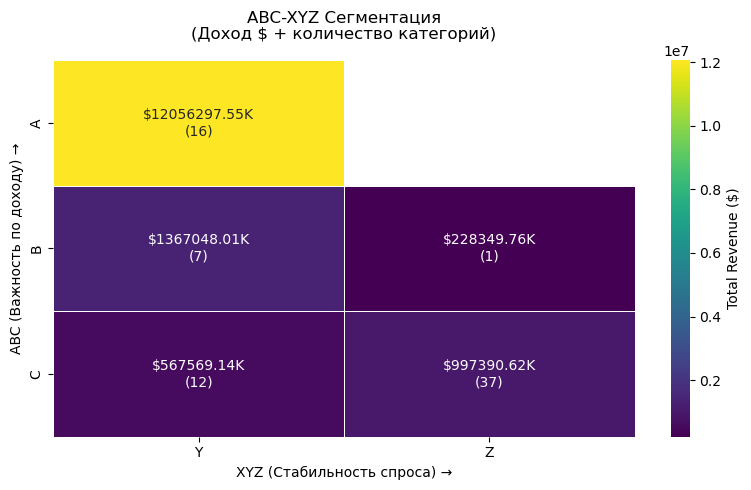

In [52]:
revenue_tab = pd.crosstab(
    index=df_abc_xyz['ABC'],
    columns=df_abc_xyz['XYZ'],
    values=df_abc_xyz['total_revenue'],
    aggfunc='sum'
)

count_tab = pd.crosstab(
    index=df_abc_xyz['ABC'],
    columns=df_abc_xyz['XYZ']
)

# Create combined annotations
annotations = np.array([
    [f"${revenue}K\n({count})" 
     for revenue, count in zip(revenue_row, count_row)]
    for revenue_row, count_row in zip(revenue_tab.values, count_tab.values)
])

# Plot clean heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    revenue_tab,
    annot=annotations,
    fmt='',
    cmap='viridis',
    linewidths=0.5,
    cbar_kws={'label': 'Total Revenue ($)'}
)

plt.title('ABC-XYZ Сегментация\n(Доход $ + количество категорий)', pad=15)
plt.xlabel('XYZ (Стабильность спроса) →')
plt.ylabel('ABC (Важность по доходу) →')
plt.tight_layout()
plt.show()

In [53]:
df_agg = df_abc_xyz.groupby(['ABC', 'XYZ', 'product_category_name_english']).agg({
    'total_revenue': 'sum',
    'CoV': 'mean'
}).reset_index()

# 2. Создаем иерархическую treemap-диаграмму
fig = px.treemap(
    df_agg,
    path=['ABC', 'XYZ', 'product_category_name_english'],
    values='total_revenue',
    color='CoV',
    color_continuous_scale='RdYlGn_r',
    color_continuous_midpoint=df_agg['CoV'].median(),
    hover_data={
        'total_revenue': ':.0f',
        'CoV': ':.2f',
        'product_category_name_english': False
    },
    title='ABC-XYZ Сегментация товаров<br><sub>Размер=Выручка, Цвет=Стабильность спроса (CoV)</sub>'
)

# 3. Настраиваем всплывающие подсказки
fig.update_traces(
    hovertemplate=(
        "<b>%{label}</b><br>"
        "Сегмент: %{parent}<br>"
        "Выручка: %{customdata[0]:,.0f} руб.<br>"
        "Стабильность спроса (CoV): %{customdata[1]:.2f}<br>"
        "%{percentParent:.1%} от родительского сегмента"
    ),
    textinfo="label+value"
)

# 4. Настраиваем оформление
fig.update_layout(
    margin=dict(t=50, l=0, r=0, b=0),
    height=700,
    coloraxis_colorbar=dict(
        title='Коэффициент вариации →',
        titleside='right',
        tickvals=[df_agg['CoV'].min(), 
                 df_agg['CoV'].median(), 
                 df_agg['CoV'].max()],
        ticktext=['Стабильный', 'Средний', 'Нестабильный']
    )
)

fig.show()